In [4]:
##get record id dataset join with medication, from all v1 and v2
##medication only available on V1 and V2
##get differences if medication is taken vs not taken on one sample (take 3 people)
##and compare the features

In [1]:
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

In [104]:
## dirty way of getting some preliminary data
GROUPED_RID = "syn21627708"
syn = sc.login()
data = query.get_file_entity(syn, GROUPED_RID)
data = data[[feat for feat in data.columns if ("window" not in feat) and ("steps" not in feat) 
             and (feat != "index") and ("valrange" not in feat)]]

# filter datasets
active_data = data[(data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE")]

passive_data = data[(data["age"] > 0) & 
            (data["table_version"] == "MPOWER_PASSIVE")]


# cols of choice
metadata_cols = ["test_type", "phoneInfo", "age", "gender", "table_version", "appVersion", "createdOn", "class"]
feat_cols = [feat for feat in active_data.columns if (feat not in metadata_cols)]

# subset data and map test class
train = active_data[feat_cols].drop(["recordId", "healthCode"], axis = 1)
target = active_data["test_type"].map({"walking":1, "balance":0})

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [105]:
medication_query_v1 = syn.tableQuery("select recordId, 'momentInDayFormat.json.choiceAnswers' as med_time \
                                    FROM syn10308918").asDataFrame().reset_index(drop = True)

medication_query_v2 = syn.tableQuery("select recordId, 'answers.medicationTiming' as med_time \
                                    FROM syn12514611").asDataFrame().reset_index(drop = True)

In [106]:
med_df = pd.concat([medication_query_v1, medication_query_v2])

In [107]:
med_df.med_time.unique()

array(["I don't take Parkinson medications",
       'Just after Parkinson medication (at your best)', 'Another time',
       nan, 'Immediately before Parkinson medication', '[]',
       'No Tracked Medication',
       'Immediately before taking Parkinson medication',
       'Just after taking Parkinson medication (at your best)',
       'Just after', 'Immediately before'], dtype=object)

In [108]:
def annot_med_time(params):
    if not isinstance(params, str):
        return params
    params = params.lower()
    if "immediately before" in params:
        return "immediately before"
    elif "just after" in params:
        return "just after"
    elif "another time" in params:
        return "another time"
    elif "i don't take parkinson medications" in params:
        return "i don't take parkinson medications"
    else:
        return np.nan
        

In [109]:
med_df["annot_med_time"] = med_df["med_time"].apply(annot_med_time)

In [110]:
test = active_data[active_data["class"] == "PD"]
test = pd.merge(test, med_df[["recordId", "annot_med_time"]], on = "recordId", how = "inner")

In [111]:
test.groupby("healthCode").agg({"recordId":"nunique", "annot_med_time":"nunique"}).sort_values("recordId")

,recordId,annot_med_time
healthCode,,
da1eaf54-5f68-42e1-9a59-1fb8be7e4875,1,0
8a1aed7e-52b6-4951-b510-3ee3eb77a4d0,1,1
8a151c72-e599-47eb-ad77-b8f0bf3f4ea9,1,1
5f7eb26d-11b0-449a-93f6-15584d5926d9,1,0
b0ff20d2-9319-4938-bfed-14ee5af9bce8,1,1
33466738-a918-4cf2-8959-96fffa91c90c,1,1
b16bd305-6090-467b-abfd-3db781af0ff6,1,0
f6f4e048-0309-4c71-8cf5-f4df93bae60a,1,1
f6fc2d4e-245f-46ef-9699-ace24bb46773,1,0


In [113]:
## use 00831276-dad1-48ae-8fab-5a3a9b156b94
sample = test[test["healthCode"] == "b80b54cc-7323-4a1e-88cf-112051223fc5"]

In [114]:
def visualize_feature_in_classes(data, f_cols, class_target, plot_type = "dist"):
    for cols in f_cols:
        try:
            plt.figure(figsize = (12,5))
            if plot_type == "dist":
                for class_ in data[class_target].unique():
                    sns.distplot(data[cols][data[class_target] == class_].dropna(), 
                                 label = class_)
                plt.legend()
                plt.show()
            elif plot_type == "box":
                plt.figure(figsize = (12,5))
                sns.catplot(y = data[cols], 
                            x = data[class_target], 
                            kind = "box", 
                            height = 5, 
                            data = data)
                plt.legend()
                plt.show()
        except (TypeError, ValueError):
            continue

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

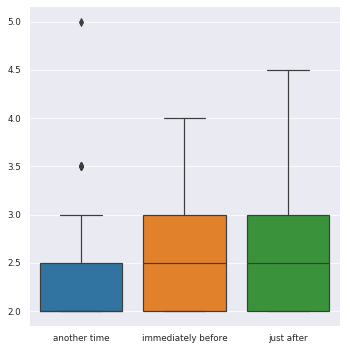

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

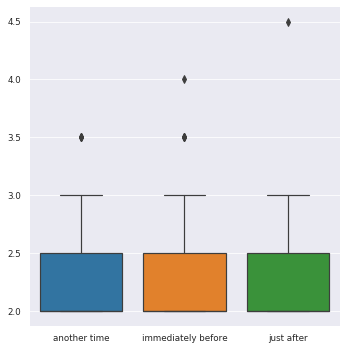

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

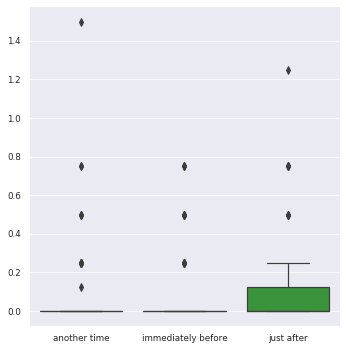

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

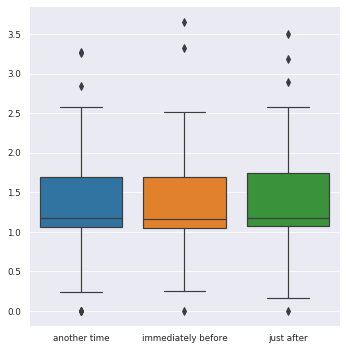

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

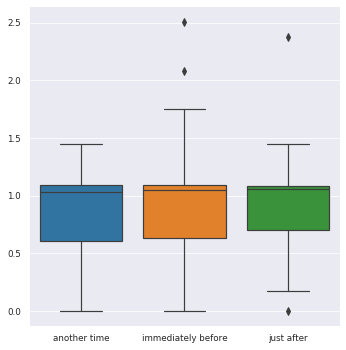

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

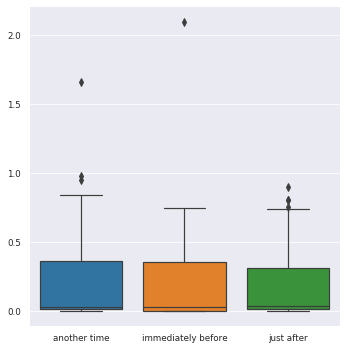

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

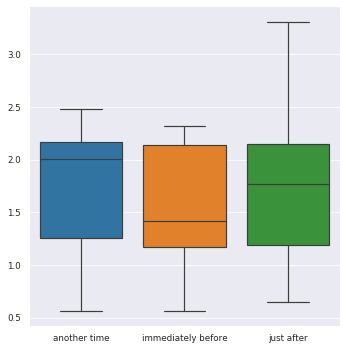

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

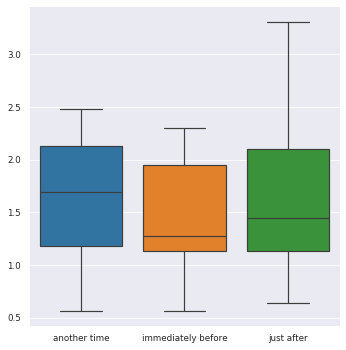

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

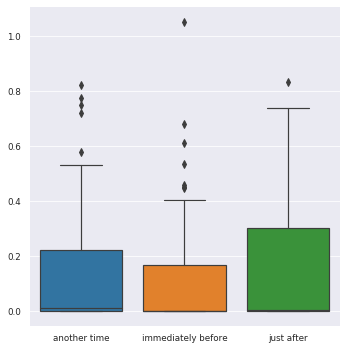

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

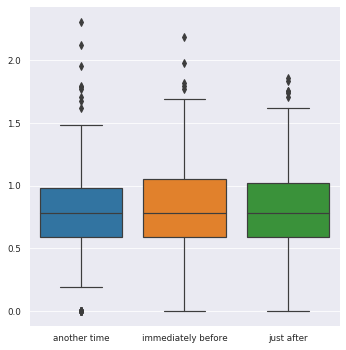

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

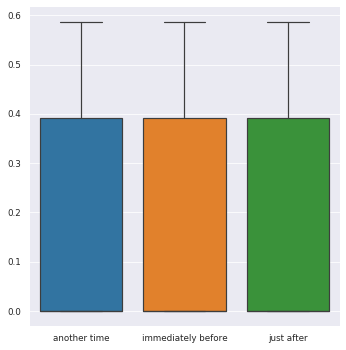

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

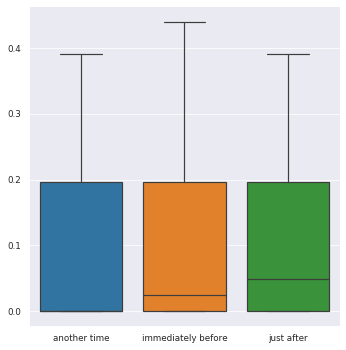

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

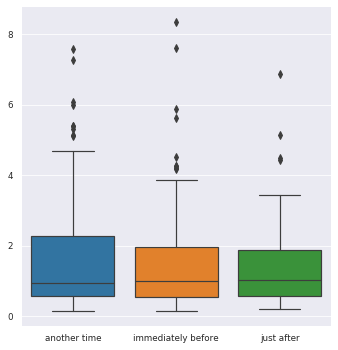

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

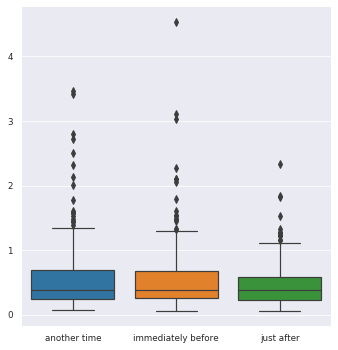

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

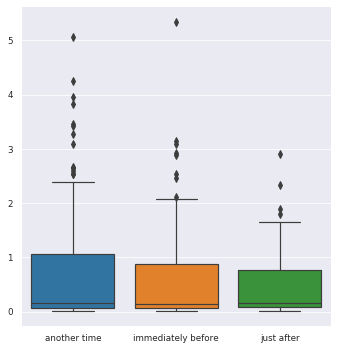

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

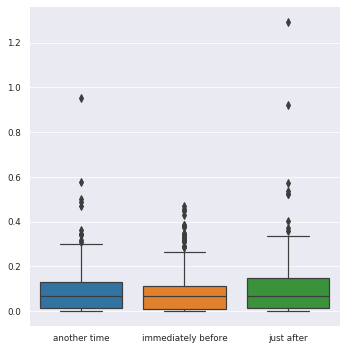

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

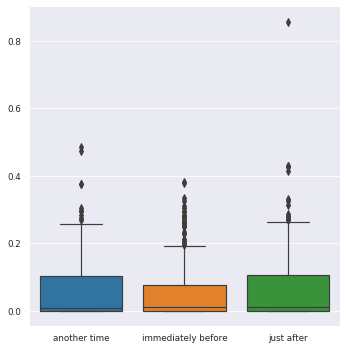

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

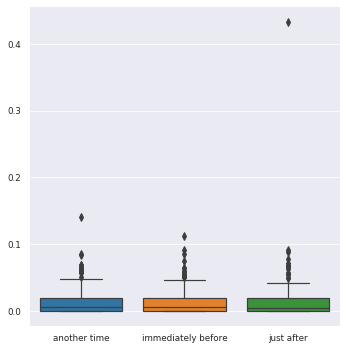

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

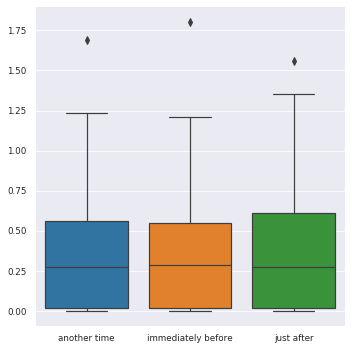

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

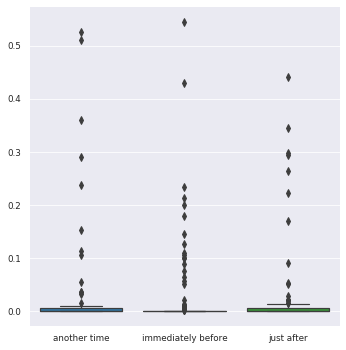

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

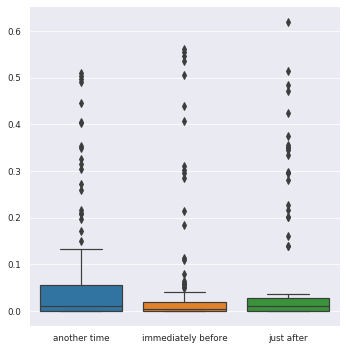

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

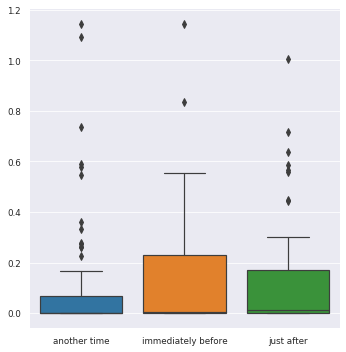

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

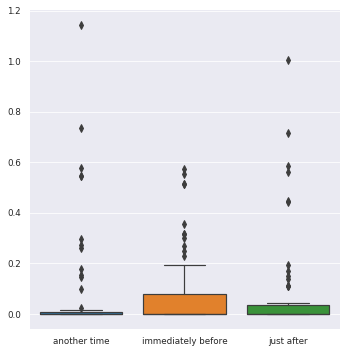

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

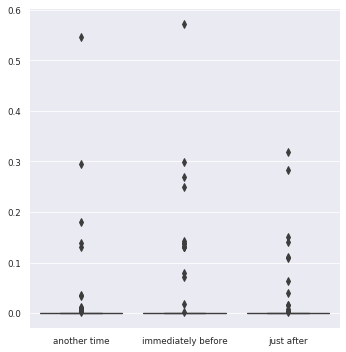

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

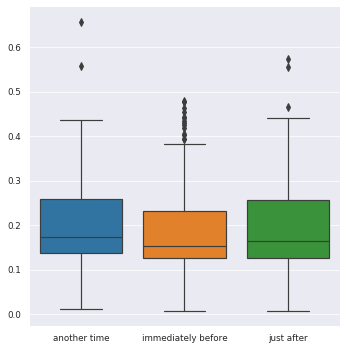

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

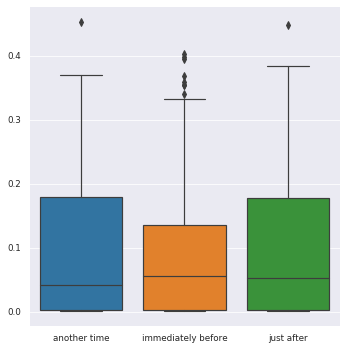

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

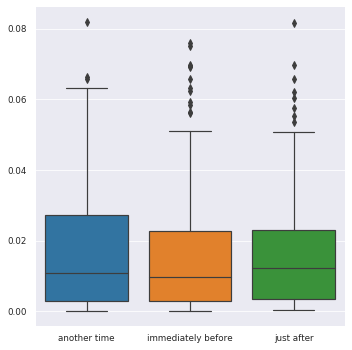

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

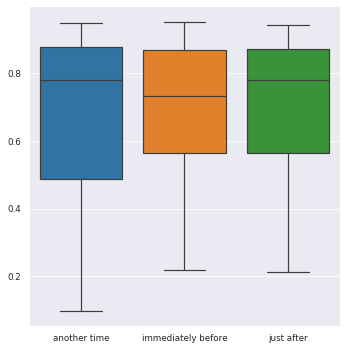

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

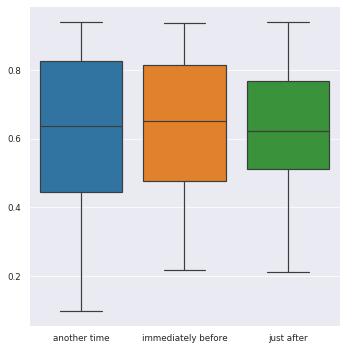

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

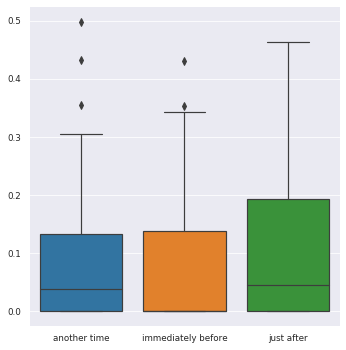

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

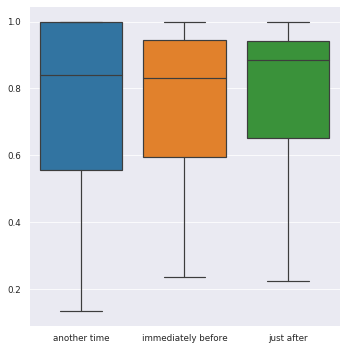

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

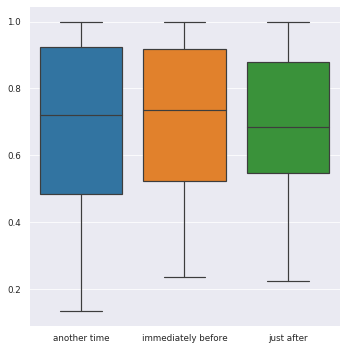

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

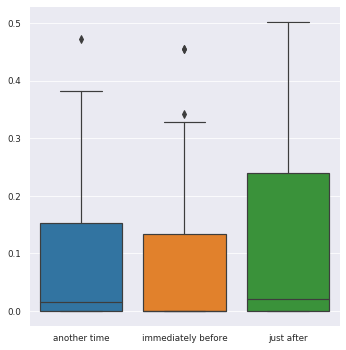

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

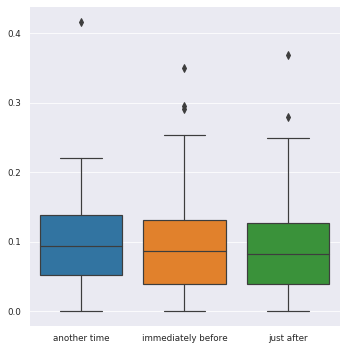

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

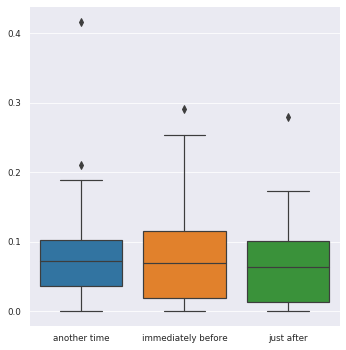

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

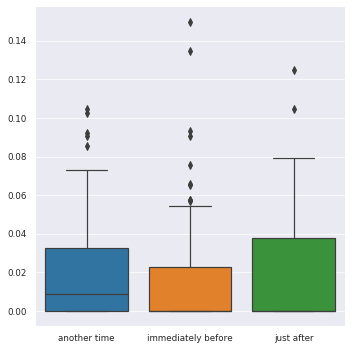

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

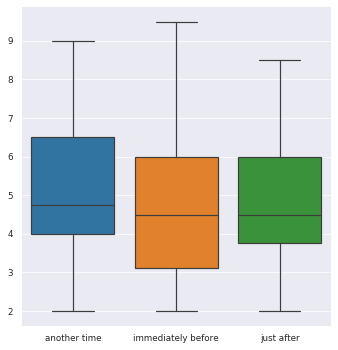

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

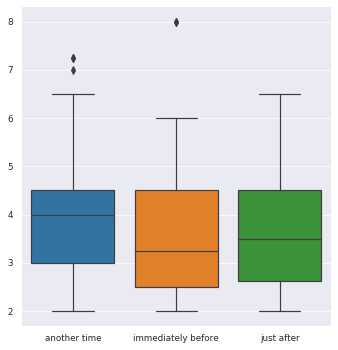

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

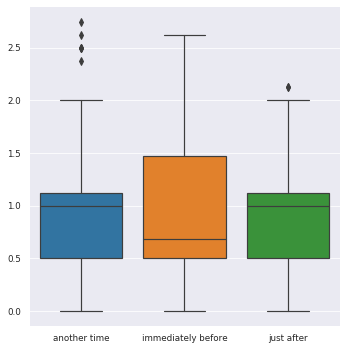

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

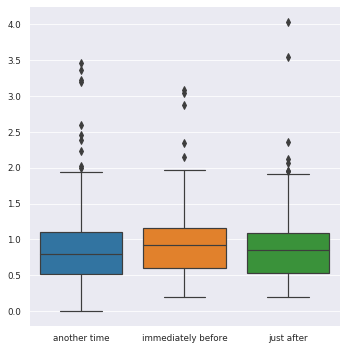

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

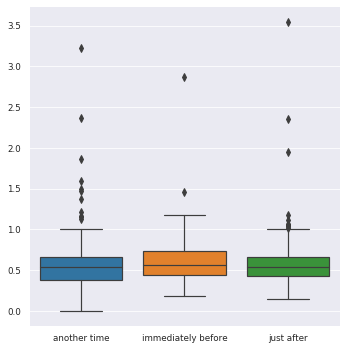

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

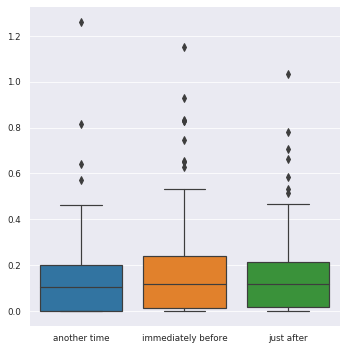

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

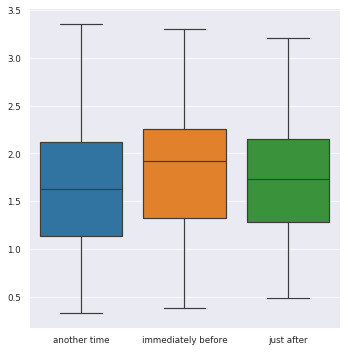

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

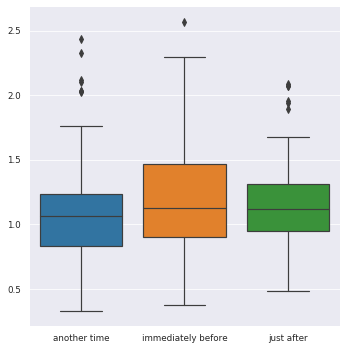

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

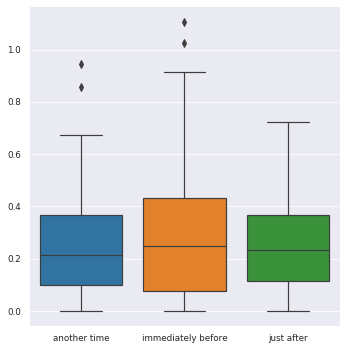

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

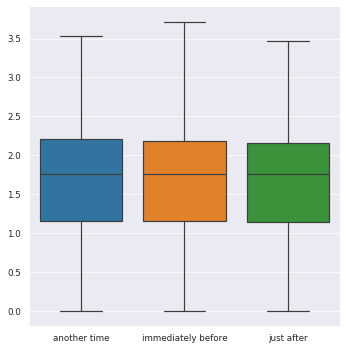

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

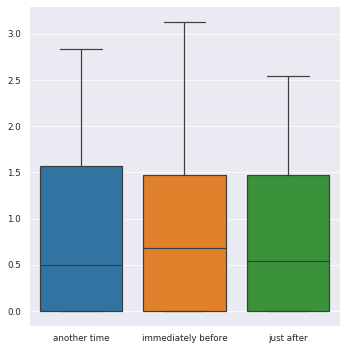

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

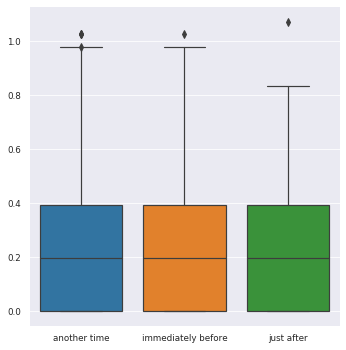

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

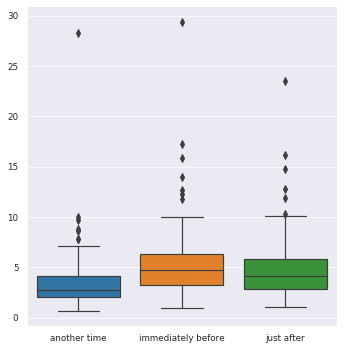

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

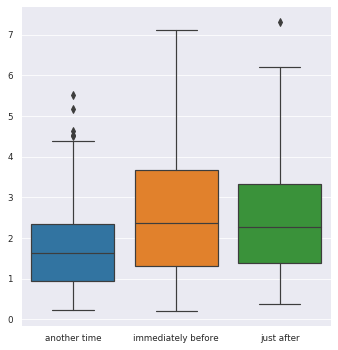

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

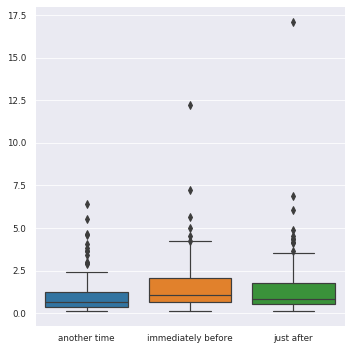

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

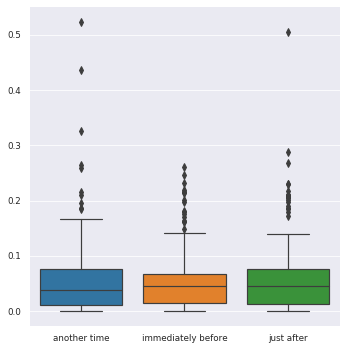

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

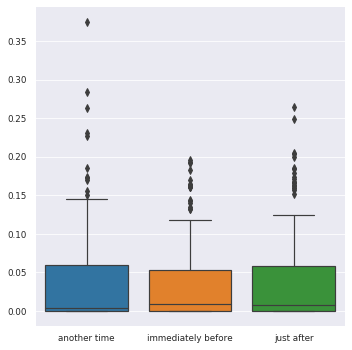

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

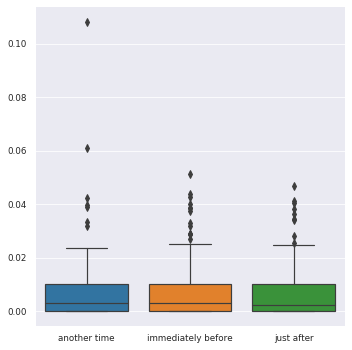

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

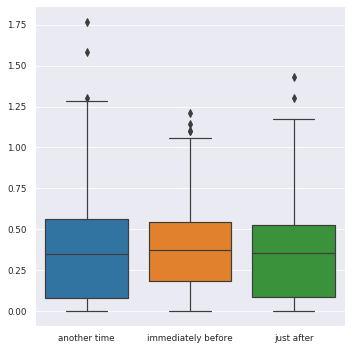

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

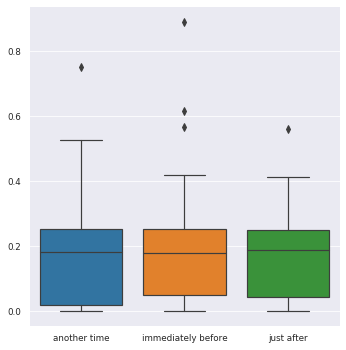

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

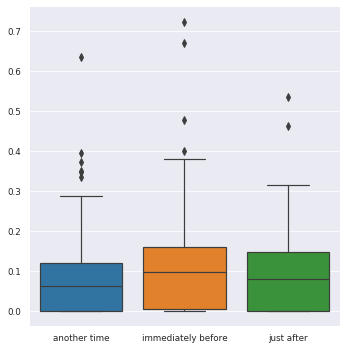

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

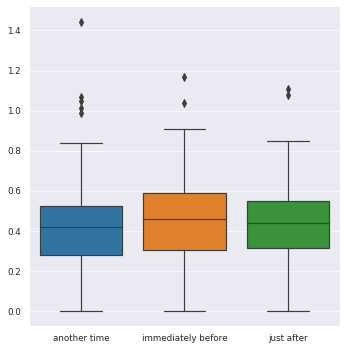

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

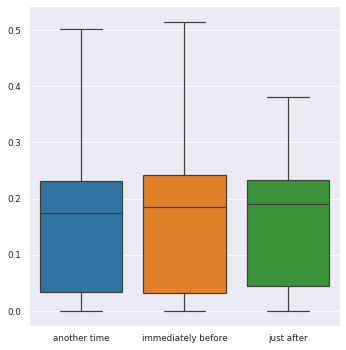

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

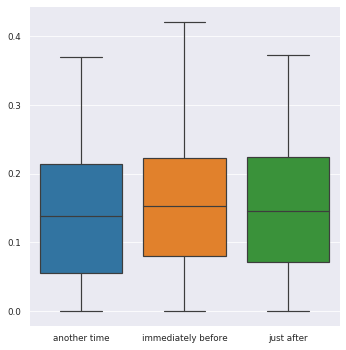

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

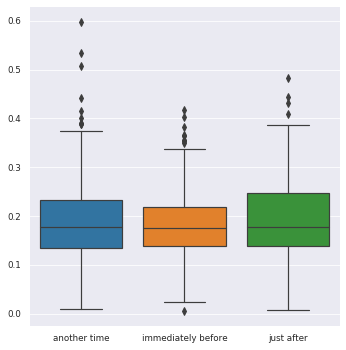

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

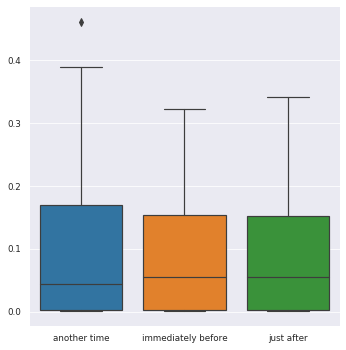

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

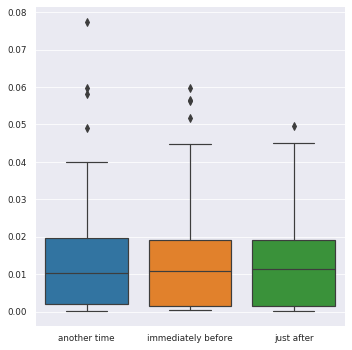

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

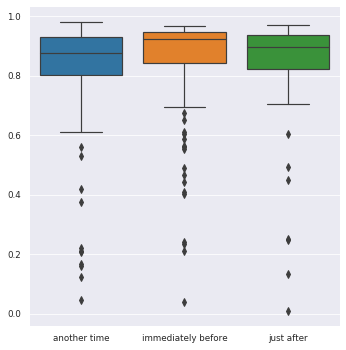

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

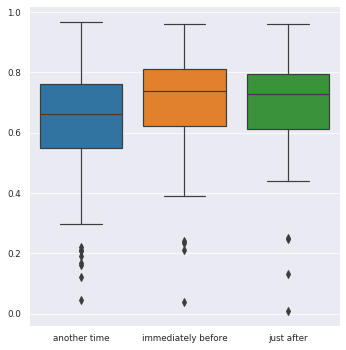

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

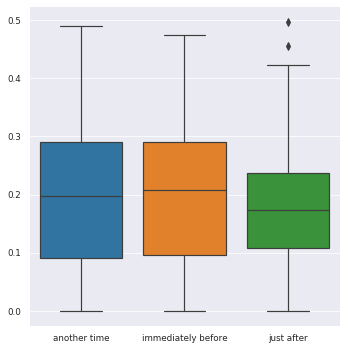

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

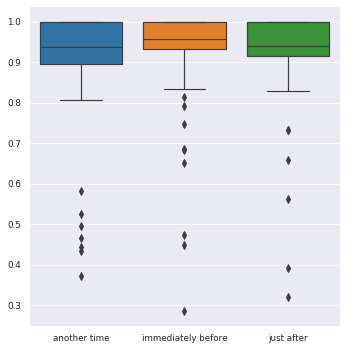

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

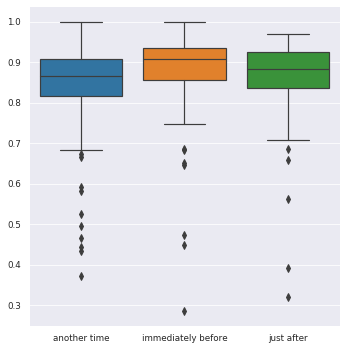

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

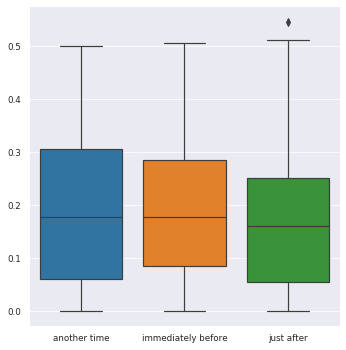

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

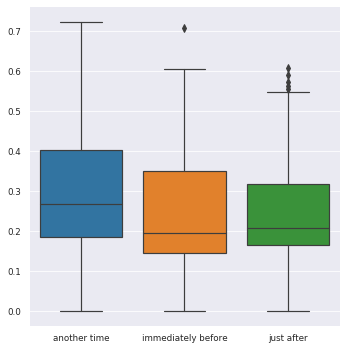

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

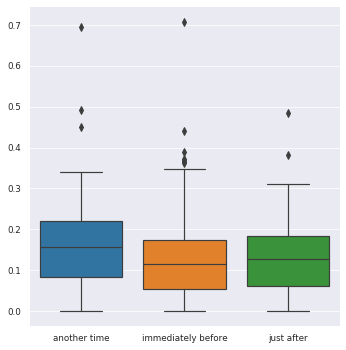

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

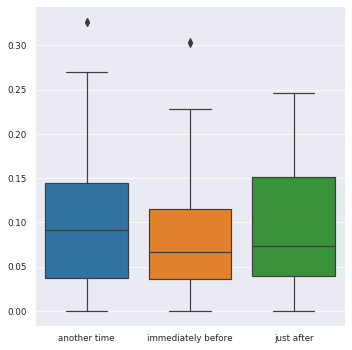

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

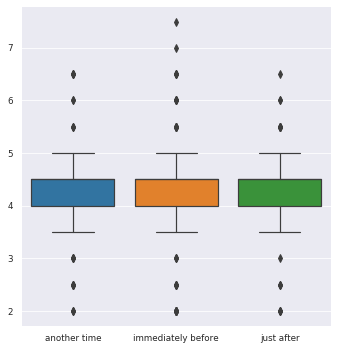

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

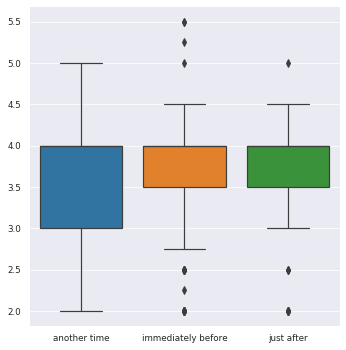

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

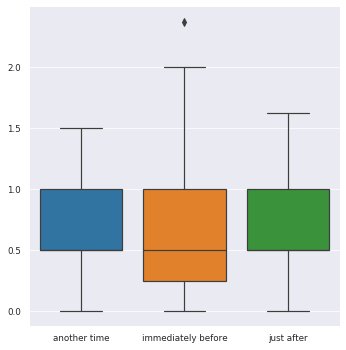

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

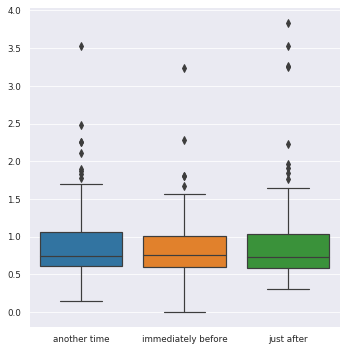

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

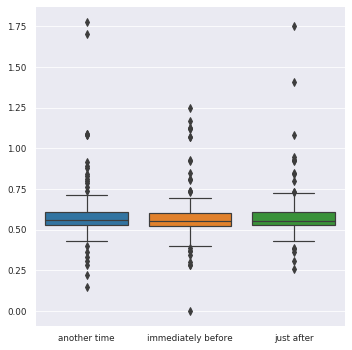

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

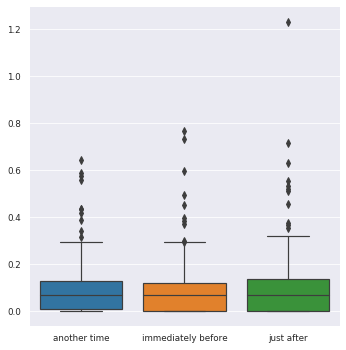

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

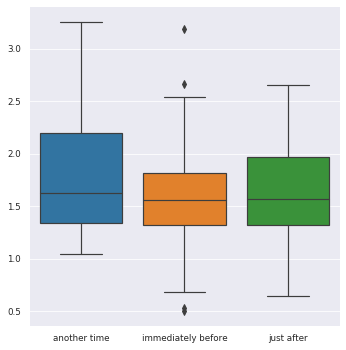

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

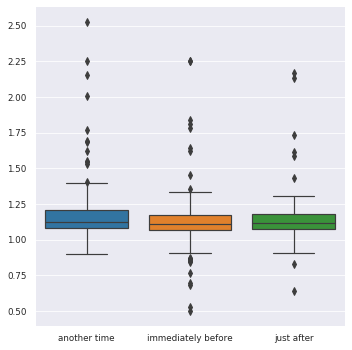

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

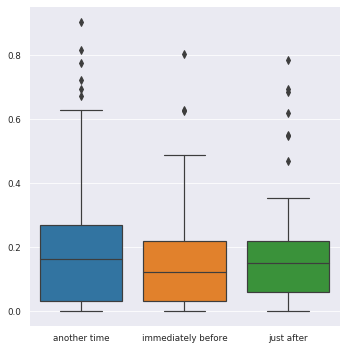

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

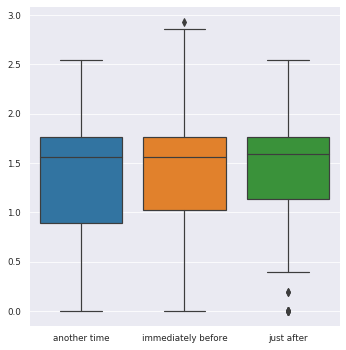

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

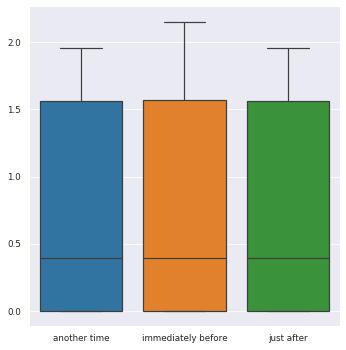

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

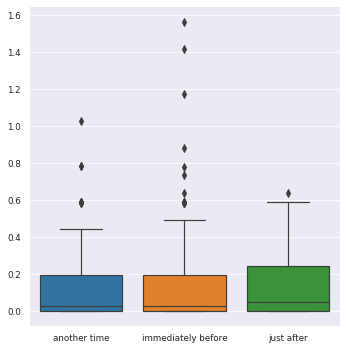

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

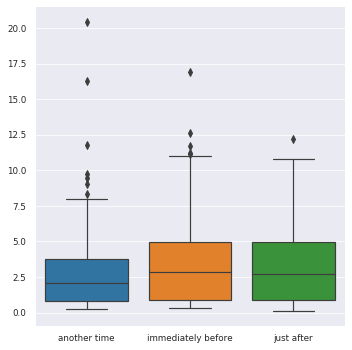

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

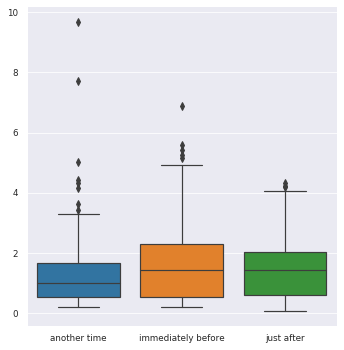

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

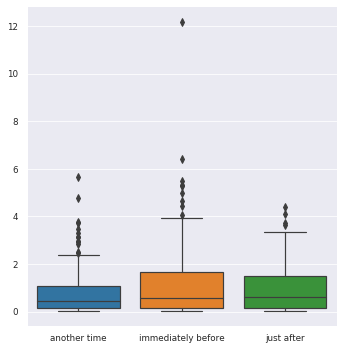

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

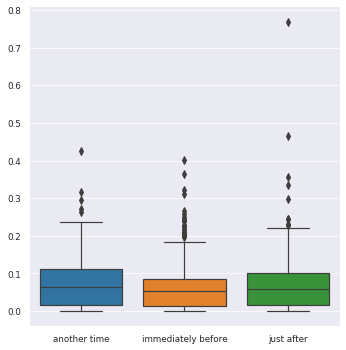

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

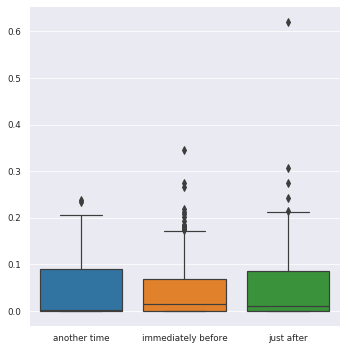

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

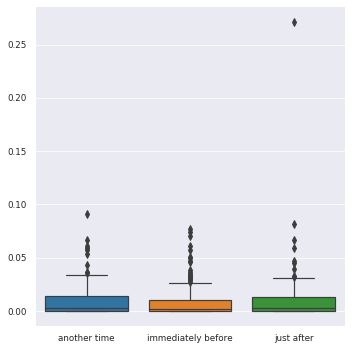

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

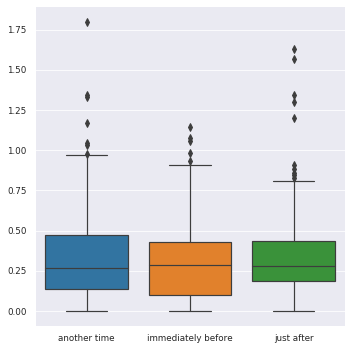

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

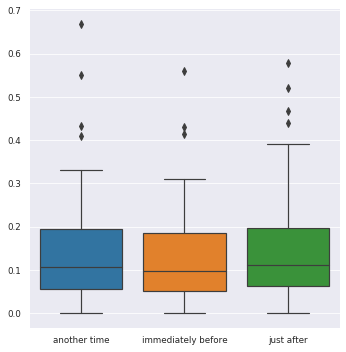

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

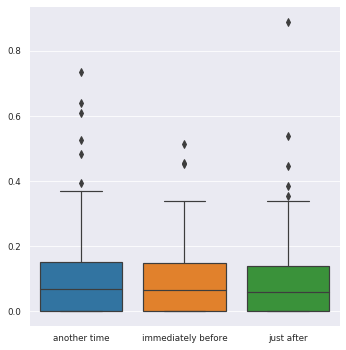

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

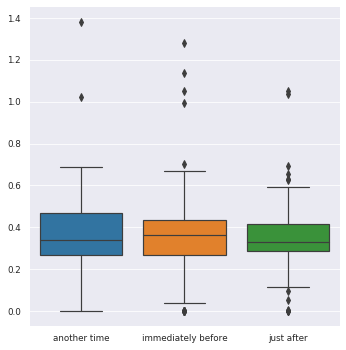

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

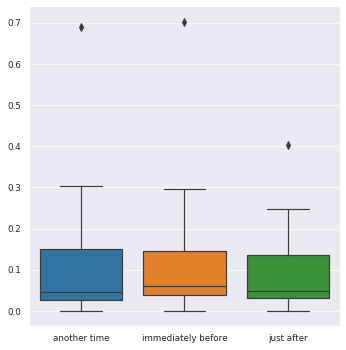

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

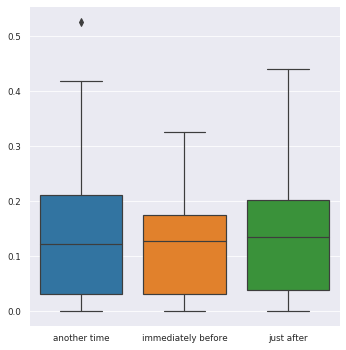

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

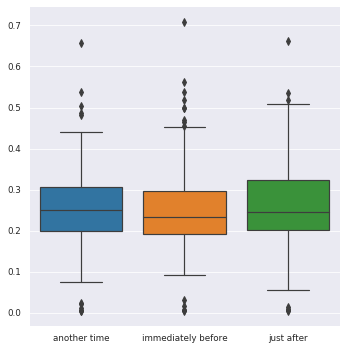

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

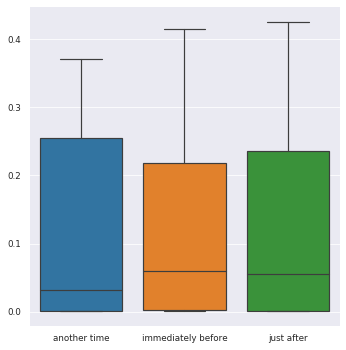

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

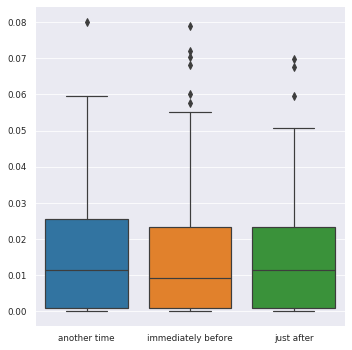

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

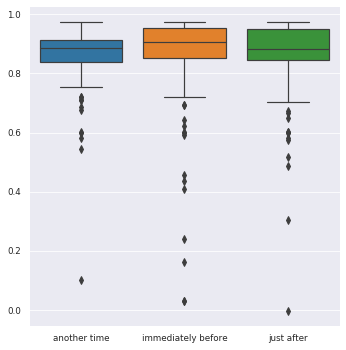

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

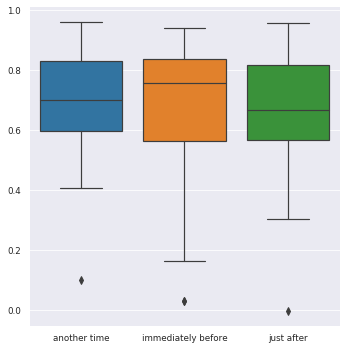

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

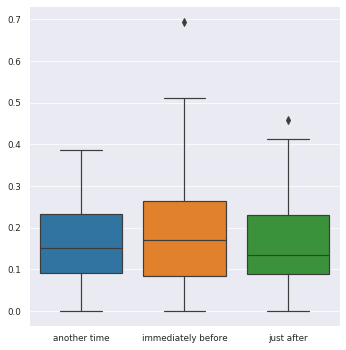

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

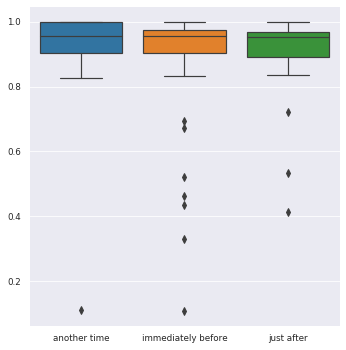

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

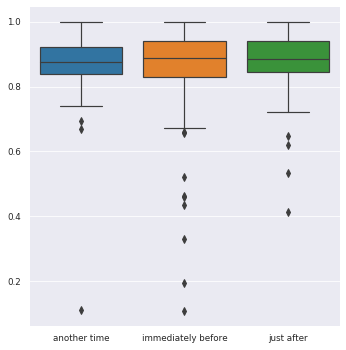

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

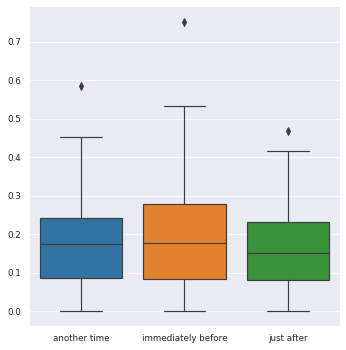

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

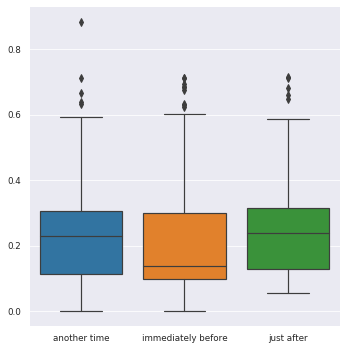

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

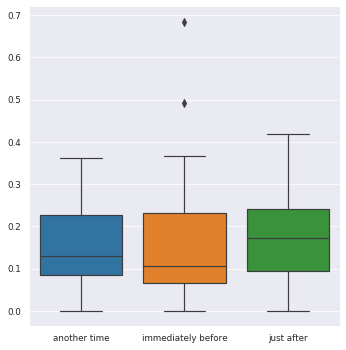

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

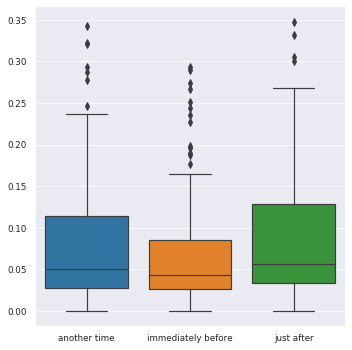

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

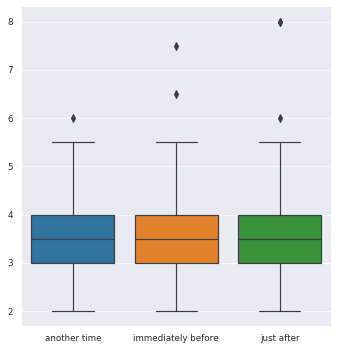

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

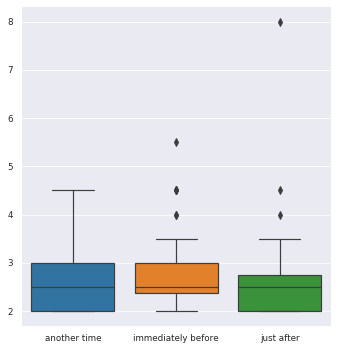

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

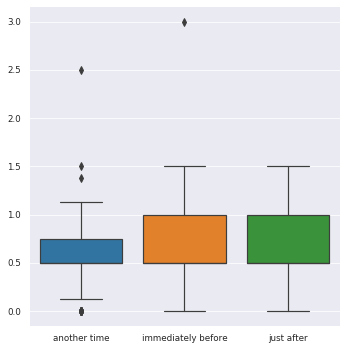

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

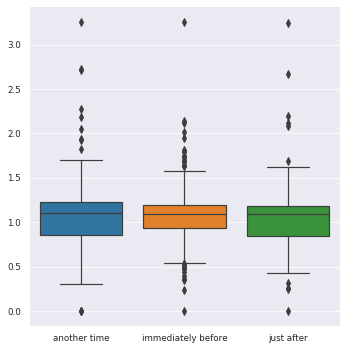

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

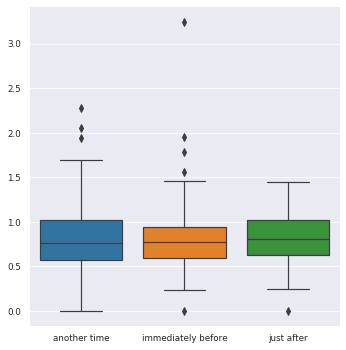

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

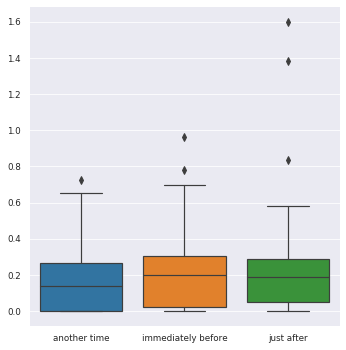

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

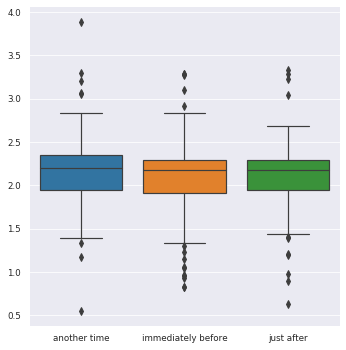

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

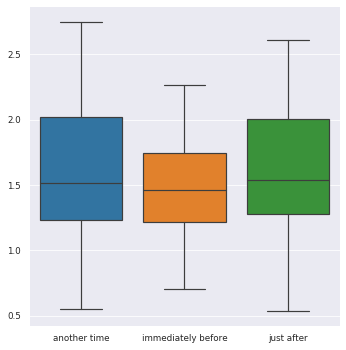

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

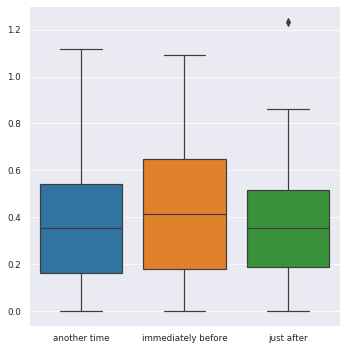

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

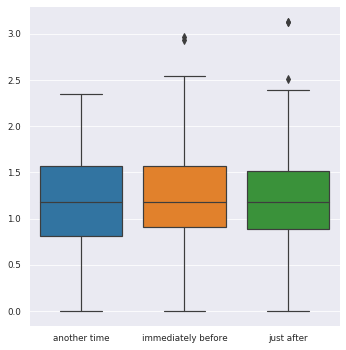

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

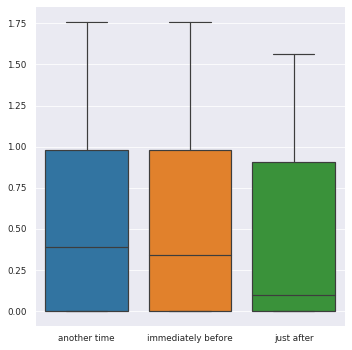

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

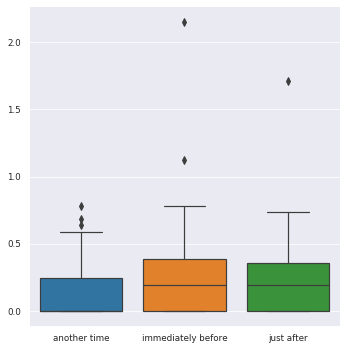

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

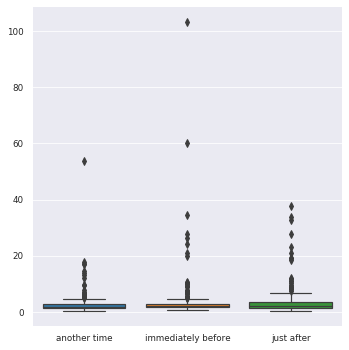

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

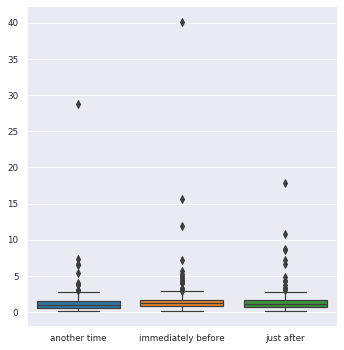

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

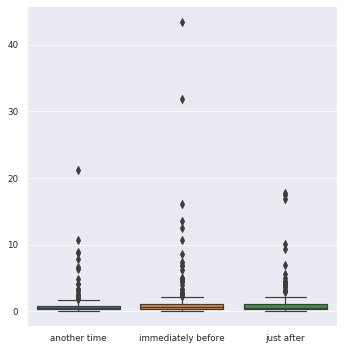

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

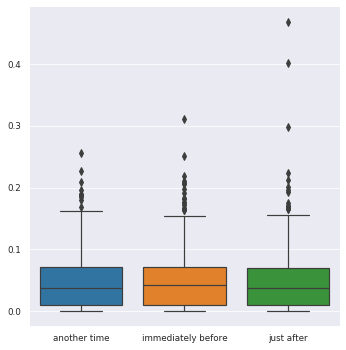

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

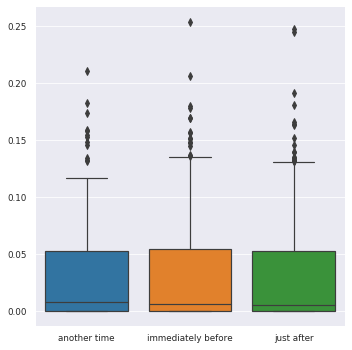

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

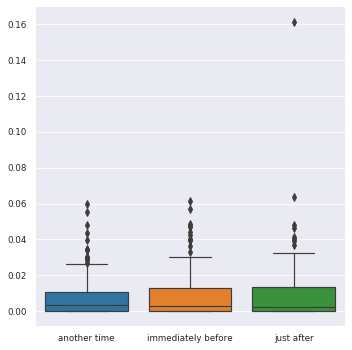

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

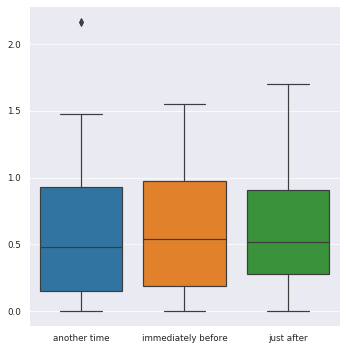

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

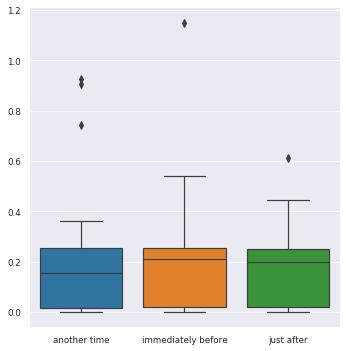

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

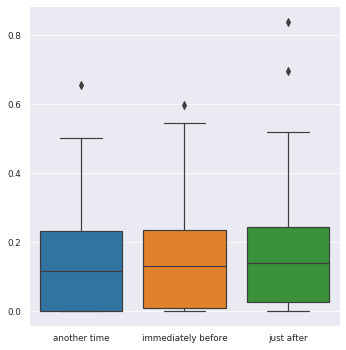

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

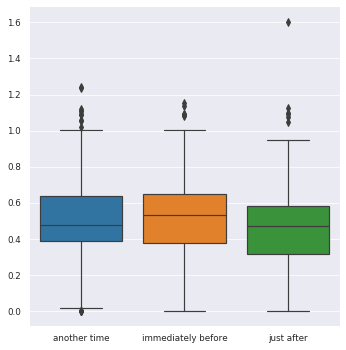

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

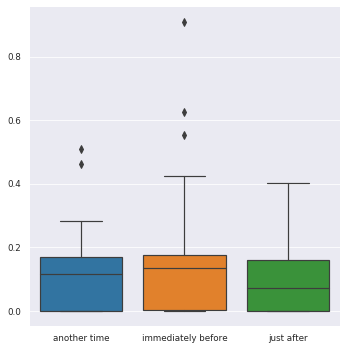

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

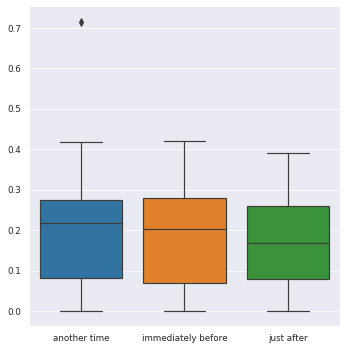

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

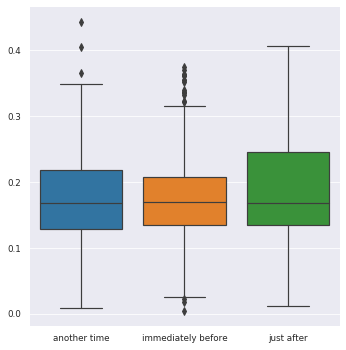

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

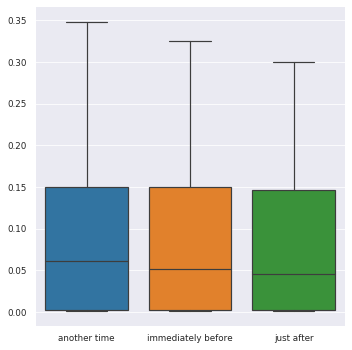

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

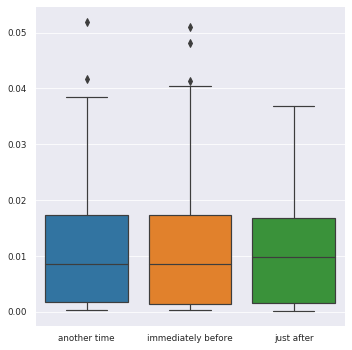

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

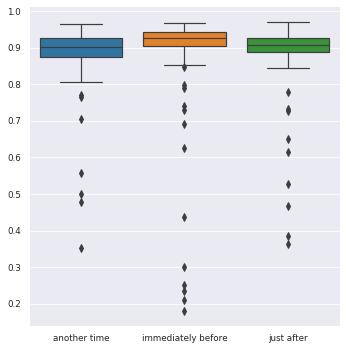

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

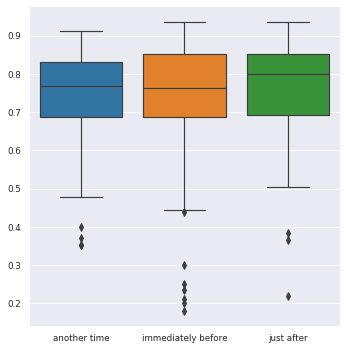

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

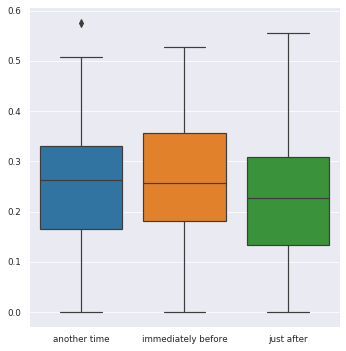

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

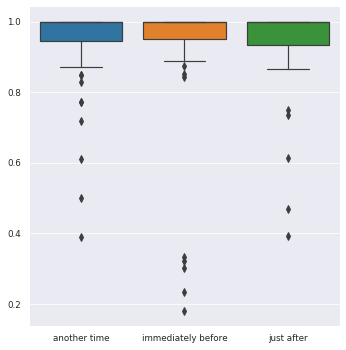

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

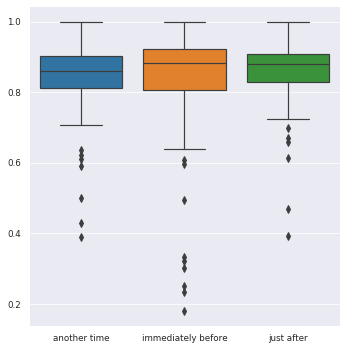

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

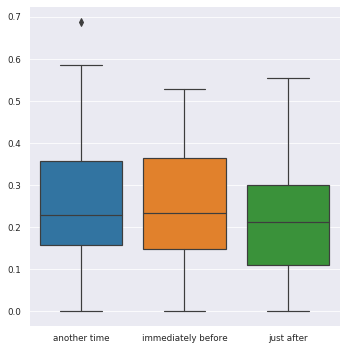

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

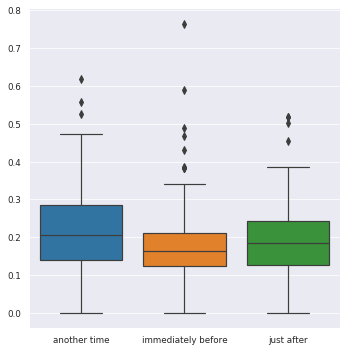

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

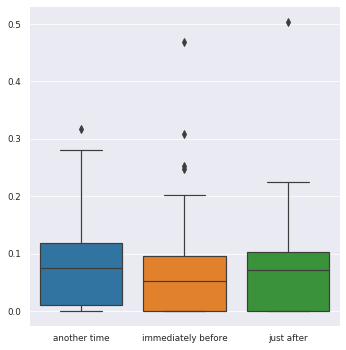

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

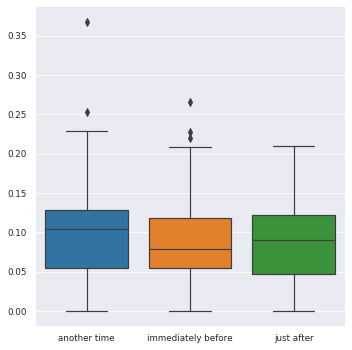

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

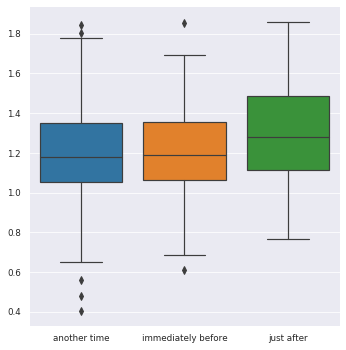

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

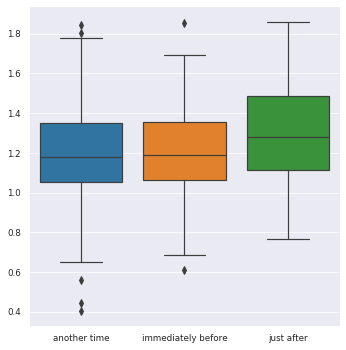

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

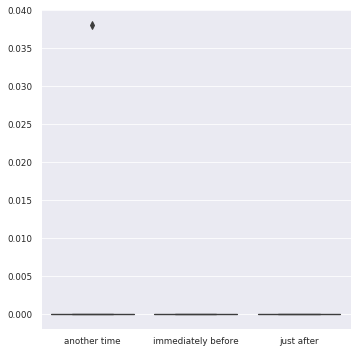

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [115]:
visualize_feature_in_classes(sample, feat_cols, "annot_med_time", "box")